# Phase 1: Exploratory Data Analysis (EDA) & Feature Engineering
**Project:** Nigerian-Context Fraud Detection System
**Goal:** Identify patterns in Nigerian financial transactions and engineer features that capture local fraud behaviors (USSD drains, midnight spikes, etc.).

### Objectives:
1. Load the synthetic Nigerian transaction data.
2. Analyze the distribution of fraud across different "Naira Bands."
3. Engineer 20+ features for our ML models.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.logger import get_logger
from pathlib import Path

# Initialize logger for the notebook
logger = get_logger("notebook_eda")

# Set visual style
plt.style.use('fivethirtyeight')
%matplotlib inline

# Load the data

filepath = Path("../../data/nigerian_transactions.csv").resolve()
df = pd.read_csv(filepath)
df['timestamp'] = pd.to_datetime(df['timestamp'])

logger.info("Data loaded and timestamp converted.")
df.head()

[2025-12-27 17:39:33] INFO [notebook_eda.<module>:22] Data loaded and timestamp converted.


,timestamp,user_id,amount,user_avg_amount,user_balance,channel,location,sender_bank,is_fraud
0,2024-01-01 00:00:00.000,USR_1698,9440.79,8639.597847,974015.743813,POS,PH,Access,0
1,2024-01-01 01:00:01.800,USR_1574,137580.50,8865.043325,585329.657222,USSD,Lagos,Access,0
2,2024-01-01 00:00:03.600,USR_1762,2354.48,2284.201965,305081.061777,POS,Abuja,Kuda,0
3,2024-01-01 00:00:05.400,USR_1487,14999.17,13629.593502,846454.246484,POS,Abuja,Kuda,0
4,2024-01-01 00:00:07.200,USR_1207,7366.88,7068.922401,255715.795608,USSD,Abuja,GTBank,0


## 1. Contextual Analysis: The "Naira Band"
In the Nigerian ecosystem, fraud often follows specific amount patterns.
* **Micro-transactions:** Airtime/Data top-ups (Small amounts).
* **Target Bands:** ₦50,000 to ₦200,000 (Common daily limits/drain targets).


In [2]:
def engineer_initial_features(data):
    df_feat = data.copy()

    # 1. Temporal Features (WAT - West Africa Time)
    df_feat['hour'] = df_feat['timestamp'].dt.hour
    df_feat['day_of_week'] = df_feat['timestamp'].dt.dayofweek

    # Flag: Midnight transactions (12AM - 4AM) - High risk in Nigeria
    df_feat['is_midnight'] = df_feat['hour'].between(0, 4).astype(int)

    # 2. Amount Bands (Naira specific)
    df_feat['amount_band'] = pd.cut(
        df_feat['amount'],
        bins=[-np.inf, 5000, 50000, 200000, np.inf],
        labels=['micro', 'small', 'medium', 'high']
    )

    # 3. Channel Risk
    df_feat['is_ussd'] = (df_feat['channel'] == 'USSD').astype(int)

    logger.info("Initial features engineered: hour, day_of_week, is_midnight, amount_band, is_ussd")
    return df_feat


df_engineered = engineer_initial_features(df)
df_engineered.head()

[2025-12-27 17:39:33] INFO [notebook_eda.engineer_initial_features:21] Initial features engineered: hour, day_of_week, is_midnight, amount_band, is_ussd


,timestamp,user_id,amount,user_avg_amount,user_balance,channel,location,sender_bank,is_fraud,hour,day_of_week,is_midnight,amount_band,is_ussd
0,2024-01-01 00:00:00.000,USR_1698,9440.79,8639.597847,974015.743813,POS,PH,Access,0,0,0,1,small,0
1,2024-01-01 01:00:01.800,USR_1574,137580.50,8865.043325,585329.657222,USSD,Lagos,Access,0,1,0,1,medium,1
2,2024-01-01 00:00:03.600,USR_1762,2354.48,2284.201965,305081.061777,POS,Abuja,Kuda,0,0,0,1,micro,0
3,2024-01-01 00:00:05.400,USR_1487,14999.17,13629.593502,846454.246484,POS,Abuja,Kuda,0,0,0,1,small,0
4,2024-01-01 00:00:07.200,USR_1207,7366.88,7068.922401,255715.795608,USSD,Abuja,GTBank,0,0,0,1,small,1


## 2. Visualizing Fraud Distribution

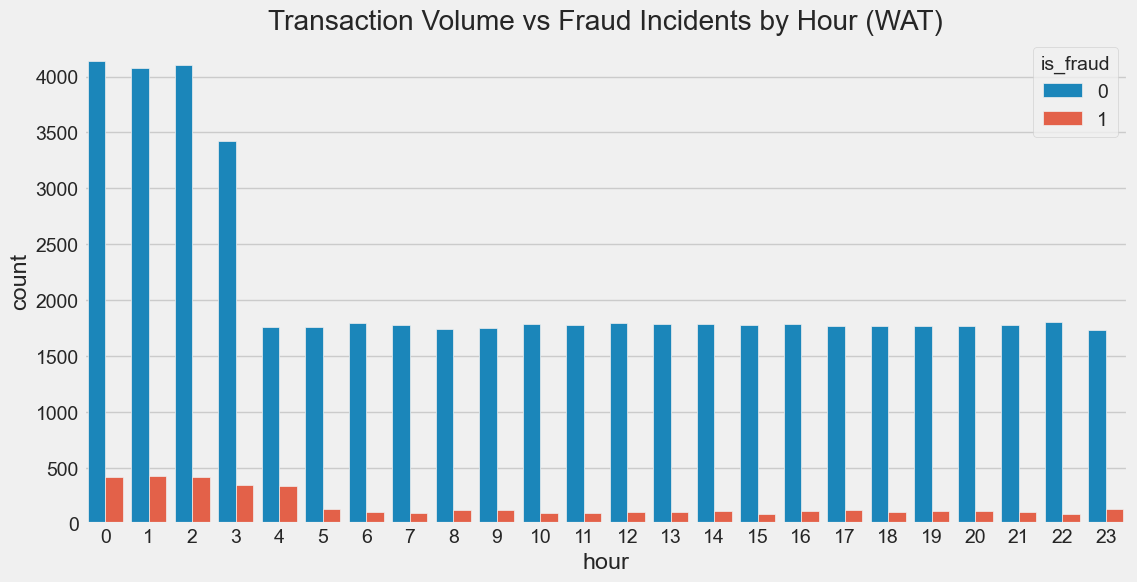

In [3]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_engineered, x='hour', hue='is_fraud')
plt.title('Transaction Volume vs Fraud Incidents by Hour (WAT)')
plt.show()

## 3. Advanced Feature Engineering: Transaction Velocity
Fraudsters often perform "Account Probing" or "Rapid Draining."
We will calculate:
* **Transaction Count (Last 24h):** Frequency of transactions from the same bank/location.
* **Amount Deviation:** Is this ₦200,000 transfer "normal" for this specific channel?

In [4]:
def engineer_velocity_features(data):
    df_v = data.copy()

    df_v['timestamp'] = pd.to_datetime(df_v['timestamp'])
    df_v = df_v.sort_values('timestamp')

    # Timestamp as index for rolling
    df_v = df_v.set_index('timestamp')

    # 1. Transaction count in last 24 hours
    tx_count_24h = (
        df_v
        .groupby(['sender_bank', 'location'])['amount']
        .rolling('24h')
        .count()
        .reset_index(level=[0, 1], drop=True)
    )

    df_v['tx_count_24h'] = tx_count_24h.values

    # 2. Total spend in last 24 hours
    total_spend_24h = (
        df_v
        .groupby(['sender_bank', 'location'])['amount']
        .rolling('24h')
        .sum()
        .reset_index(level=[0, 1], drop=True)
    )

    df_v['total_spend_24h'] = total_spend_24h.values

    # 3. Average transaction value deviation
    df_v['avg_tx_amount'] = (
        df_v.groupby('sender_bank')['amount'].transform('mean')
    )

    df_v['amount_vs_avg_ratio'] = (
        df_v['amount'] / df_v['avg_tx_amount']
    )

    # Restore timestamp column
    df_v = df_v.reset_index()

    logger.info(
        "Velocity features engineered: tx_count_24h, total_spend_24h, amount_vs_avg_ratio"
    )

    return df_v


df_final = engineer_velocity_features(df_engineered)

[2025-12-27 17:39:36] INFO [notebook_eda.engineer_velocity_features:44] Velocity features engineered: tx_count_24h, total_spend_24h, amount_vs_avg_ratio


## 4. Advanced Behavioral Engineering
Now that our data includes user history (`user_avg_amount` and `user_balance`), we can engineer features that detect "Account Shocks."
Fraudsters usually attempt to withdraw amounts significantly higher than a user's typical behavior.

In [5]:
def engineer_advanced_behavioral(df):
    df_adv = df.copy()

    # Ensure timestamp is datetime
    df_adv['timestamp'] = pd.to_datetime(df_adv['timestamp'])

    # Sort
    df_adv = df_adv.sort_values(['user_id', 'channel', 'timestamp'])

    # 1. Shock ratio
    df_adv['amt_to_user_avg_ratio'] = df_adv['amount'] / df_adv['user_avg_amount']

    # 2. Drain %
    df_adv['pct_of_balance'] = (df_adv['amount'] / df_adv['user_balance']) * 100

    # 3. Location & bank risk
    df_adv['amt_to_location_avg_ratio'] = df_adv['amount'] / df_adv.groupby('location')['amount'].transform('mean')
    df_adv['amt_to_bank_avg_ratio'] = df_adv['amount'] / df_adv.groupby('sender_bank')['amount'].transform('mean')

    # 4. Channel velocity (1-hour rolling count) - vectorized and time-based
    df_adv['channel_velocity_1h'] = df_adv.groupby(['user_id', 'channel'], group_keys=False) \
                                         .rolling('1h', on='timestamp')['amount'] \
                                         .count() \
                                         .reset_index(drop=True)

    return df_adv



df_finals = engineer_advanced_behavioral(df_final)


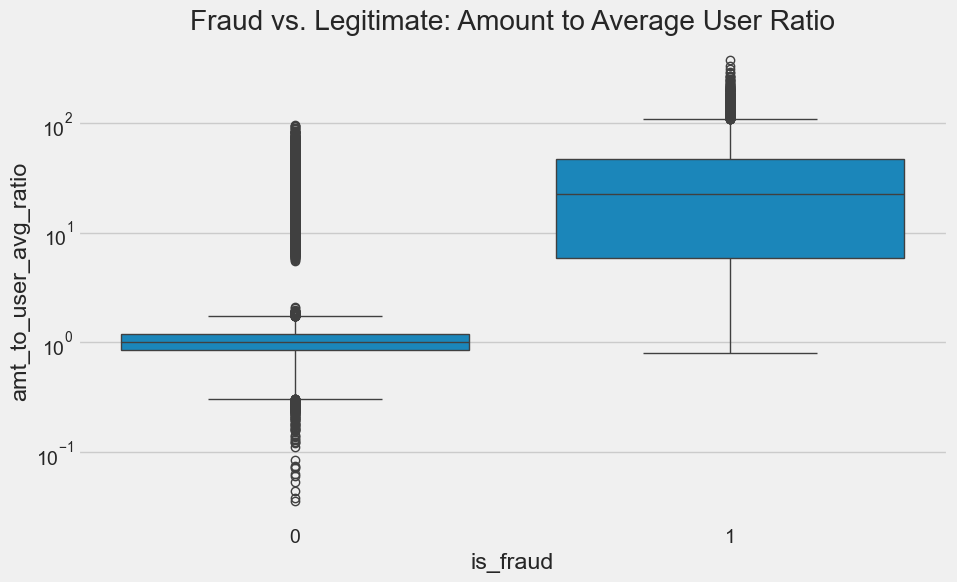

Correlation with Fraud:
is_fraud                     1.000000
amount_vs_avg_ratio          0.676669
amt_to_bank_avg_ratio        0.676669
amount                       0.676615
amt_to_location_avg_ratio    0.676269
Name: is_fraud, dtype: float64


In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt_to_user_avg_ratio', data=df_finals)
plt.yscale('log')
plt.title('Fraud vs. Legitimate: Amount to Average User Ratio')
plt.show()

# Correlation check
numeric_df = df_finals.select_dtypes(include='number')

# Correlation with 'is_fraud'
print("Correlation with Fraud:")
print(numeric_df.corr()['is_fraud'].sort_values(ascending=False).head(5))


### 5. Finalize the features Engineering

In [7]:
# 1. Drop columns
cols_to_drop = ['timestamp', 'transaction_id', 'user_id']
ml_ready_df = df_final.drop(columns=cols_to_drop, errors='ignore')

# 2. Save as Parquet
file_output = '../../data/nigerian_fraud_gold.parquet'
ml_ready_df.to_parquet(file_output, index=False)

logger.info(f"Gold Data Saved! Shape: {ml_ready_df.shape}")

[2025-12-27 17:39:40] INFO [notebook_eda.<module>:9] Gold Data Saved! Shape: (55200, 16)
